# In this notebook, we define a simple Python-based Molecular Dynamics engine which will allow for the use of ML-based Ab-Initio Molecular Dynamics Analogues.

In [245]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import numpy.random as rand
import numpy.linalg as la
from sklearn.kernel_ridge import KernelRidge

## Change this according to your local environment to point to the 'util' folder

In [246]:
sys.path.append(os.environ['PROJDIR']+'/util')
sys.path.append('/Users/steven/Documents/Research/Projects/MLED/ML-electron-density/util')

First, we define the engine which will power the whole simulation.

The engine object needs to keep track of every atom's individual position, and will propagate the system forward by computing the forces acting on each atom and then propagating forward by a time step.

In [247]:
class MD_engine():
    
    def __init__(self,input_atoms=[],cell=np.eye(3), dx=.1,verbosity=1,model='SHO',store_trajectory=True,
                espresso_config=None,thermo_config=None,ML_model = None,assert_boundaries=True, fd_accuracy=2):
        """
        Initialize the features of the system, which include:
        input_atoms: Atoms in the unit cell, list of objects of type Atom (defined later on in this notebook)
        cell:  3x3 matrix [[a11 a12 a13],..] which define the dimensions of the unit cell.
        dx:    Perturbation distance used to evaluate the forces by finite differences in potential energy.
        verbosity: integer from 0 to 5 which determines how much information will be printed about runs.
                    Ranging from 0 as silent to 5 is TMI and is mostly for debugging.
        model: The energy model used. 
        store_trajectory: Boolean which determines if positions will be saved after every time step.
        epsresso_config: Espresso_config object which determines how on-the-fly quantum espresso runs will be 
                        parameteried.
        thermo_config:   Thermo config object which determines the thermostate methodology that will be used
                        for molecular dynamics.
        ML_model: Object which parameterizes a ML model which returns energies when certain configurations are input.
        assert_boundaries : Determines if boundary conditions are asserted at the end of each position update
                            (which forces atoms to lie within the unit cell).
        fd_accuracy: Integer 2 or 4. Determines if the finite difference force calculation will be evaluated to 
                        second or fourth order in dx. Note that this increases the number of energy calculations
                        and thus increases run time.
        """
        self.verbosity = verbosity

        self.atoms = input_atoms  # Instantiate internal list of atoms, populate via helper function
        for atom in input_atoms:
            if self.verbosity==5:
                print('Loading in',atom)
        
        self.dx = dx
        self.cell = np.array(cell)
        self.model = model

        self.time = 0.
        
        self.store_trajectory=store_trajectory
        
        # Construct trajectories object 
        if store_trajectory:
            self.trajs=[]
            for n in range(len(self.atoms)):
                self.trajs.append([])
                
        # Set configurations
        self.espresso_config = espresso_config or None
        self.thermo_config = thermo_config or None
        self.ML_model = ML_model or None
        
        self.assert_boundaries = assert_boundaries
        
        self.fd_accuracy = fd_accuracy
        
    def add_atom(self,atom):
        """
        Helper function which adds atoms to the simulation
        """
        if self.verbosity==4:
            print("Adding atom",atom)
        self.atoms.append(atom)    
    

    def get_config_energy(self,atoms):
        """
        The positions of the atoms are passed to a given model of choice,
        in which the positions are converted into the configuration which is
        appropriate to be parsed by the model.

        For instance, the positions may need to be converted into 
        atom-centered symmetry functions for the Gaussian Process model. By
        passing in the positions, the necessary mapping is performed, and then
        the appropriate model is called.
        """ 
        
        # Simple Harmonic Oscillator
        if self.model=='SHO':
            return SHO_energy(atoms)
    
        #######
        # Below are 'hooks' where we will later plug in to our machine learning models
        #######
        if self.model=='GP':
            config = GP_config(positions)
            energy,uncertainty = GP_energ(config,self.ML_model)
            if np.norm(uncertainty)>.01:
                print("Warning: Uncertainty cutoff found.")
                
            return GP_energy(config,self.ML_model)

        # Kernel Ridge Regression
        if self.model=="KRR":
            # Helper function which converts atom positions into a configuration
            #  appropriate for the KRR model. Could then be modified
            #  later depending on alternate representations.
            config = KRR_config(self.atoms,self.cell)
            return KRR_energy(config,self.ML_model)

        # Lennard Jones
        if self.model=='LJ':
            
            return LJ_energy(atoms)
    
    def update_atom_forces(self):
        """
        Perturbs the atoms by a small amount dx in each direction
        and returns the gradient (and thus the force) 
        via a finite-difference approximation.
        
        Or, if the engine's model is ab-initio molecular dynamics,
        runs quantum ESPRESSO on the current configuration and then 
        stores the forces output from ESPRESSO as the atomic forces.
        """
        
        if self.model=='AIMD':
            results=run_espresso(self.atoms,self.cell,qe_config=self.espresso_config)
            
            if self.verbosity==4: print("E0:",results['energy'])
            
            force_list = results['forces']
            for n  in range(len(force_list)):
                self.atoms[n].force=list(np.array(results['forces'][n])*13.6/0.529177)
            
            return
        
        E0 = self.get_config_energy(self.atoms)
        if self.verbosity==4: print('E0:',E0)
        atoms = self.atoms
        
        # Depending on the finite difference accuracy specified at instantiation,
        # perform either 2 or 4 potential energy calculations.
        
        # Second-order finite-difference accuracy
        if self.fd_accuracy==2:
            for atom in atoms:
                for coord in range(3):
                    # Perturb the atom to the E(x+dx) position
                    atom.position[coord] += self.dx
                    Eplus = self.get_config_energy(atoms)
                    # Perturb the atom to the E(x-dx) position
                    atom.position[coord] -= 2*self.dx
                    Eminus = self.get_config_energy(atoms)
                    
                    # Return atom to initial position
                    atom.position[coord] += self.dx

                    atom.force[coord] = -first_derivative_2nd(Eminus,Eplus,self.dx)
                    if self.verbosity==5:
                        print("Just assigned force on atom's coordinate",coord," to be ", -first_derivative_2nd(Eminus,Eplus,self.dx))
        # Fourth-order finite-difference accuracy
        if self.fd_accuracy==4:
            for atom in atoms:
                for coord in range(3):
                    # Perturb the atom to the E(x+dx) position
                    atom.position[coord] += self.dx
                    Eplus = self.get_config_energy(atoms)
                    # Perturb the atom to the E(x+2dx) position
                    atom.position[coord] += self.dx
                    Epp = self.get_config_energy(atoms)
                    # Perturb the atom to the E(x-2dx) position
                    atom.position[coord] -= 4.0*self.dx
                    Emm = self.get_config_energy(atoms)
                    # Perturb the atom to the E(x-2dx) position
                    atom.position[coord] += self.dx
                    Eminus = self.get_config_energy(atoms)
                    
                    atom.position[coord] += self.dx


                    atom.force[coord] = -first_derivative_4th(Emm,Eminus,Eplus,Epp,self.dx)
                    if self.verbosity==5:
                        print("Just assigned force on atom's coordinate",coord," to be ", -first_derivative_2nd(Eminus,Eplus,self.dx))

                
        atom.apply_constraint()
        
        
    def take_timestep(self,dt,method='Verlet'):
        """
        Propagate the atoms forward by timestep dt according to it's current force and previous position.
        Note that the first time step does not have the benefit of a previous position, so, we use
        a standard third-order Euler timestep incorporating information about the velocity and the force.
        """
        temp_num=0.

        # Third-order euler method
        # Not the worst way to begin a Verlet run, see: 
        # https://en.wikipedia.org/wiki/Verlet_integration#Starting_the_iteration
        
        if method=='TO_Euler':
            for atom in atoms:
                for coord in range(3):
                    atom.prev_pos[coord] = np.copy(atom.position[coord])
                    atom.position[coord] += atom.velocity[coord]*dt+ atom.force[coord]*dt**2/atom.mass
                    atom.velocity[coord] += atom.force[coord]*dt/atom.mass
                    
        ######
        # Superior Verlet integration
        # Citation:  https://en.wikipedia.org/wiki/Verlet_integration
        ######
        elif method=='Verlet':
            for atom in self.atoms:
                for coord in range(3):
                    # Store the current position to later store as the previous position
                    # After using it to update the position
                    
                    temp_num = np.copy(atom.position[coord])
                    atom.position[coord] = 2*atom.position[coord] - atom.prev_pos[coord] + atom.force[coord]*dt**2/atom.mass
                    atom.velocity[coord] += atom.force[coord]*dt/atom.mass     
                    atom.prev_pos[coord] = np.copy(temp_num)
                    if self.verbosity==5:print("Just propagated a distance of ",atom.position[coord]-atom.prev_pos[coord])
        
        if self.store_trajectory:
            for n in range(len(self.atoms)):
                self.trajs[n].append(np.copy(self.atoms[n].position))
        self.time+=dt
    
    def run(self,tf,dt):
        """
        Handles timestepping; at each step, calculates the force and then
        advances via the take_timestep method.
        
        """
        
        # The very first timestep often doesn't have the 'previous position' to use,
        # so the third-order Euler method starts us off using information about the position,
        # velocity (if provided) and force:
        
        if self.time==0:
            self.update_atom_forces()
            self.take_timestep(dt,method='TO_Euler')
            # Assert boundary conditions (push all atoms to unit cell) if specified
            if self.assert_boundaries: self.assert_boundary_conditions()
                
            if self.verbosity>=3:
                self.print_positions()
                
        while self.time<tf:
            self.update_atom_forces()
            self.take_timestep(dt)
            if self.assert_boundaries: self.assert_boundary_conditions()

            if self.verbosity>=3:
                self.print_positions()
            
            
            # If using Gaussian processes, we may want to augment the training data set
            if self.model=='GP':
            
                valid = self.gauge_uncertainty(self.atoms,self.threshold)
                if valid:                    
                    continue
                else:
                    take_timestep(-dt)
                    self.time -=dt
                    call_dft()
                    train_model()
                

        

    def gauge_uncertainty(self,positions,threshold):
        """
        For later implementation with the Gaussian Process model.
        Will check to see if the uncertainty of the model's prediction of the energy
        within a given configuration is within an acceptable bound given by threshold.
        
        If it is unacceptable, the current configuration is exported into a Quantum ESPRESSO run,
        which is then added into the ML dataset and the model is re-trained.
        """
        config=GP_config(positions)
        sigma=get_config_uncertainty(config)
        if sigma>threshold:
            return False
        else:
            return True
        
    def assert_boundary_conditions(self):
        """
        We seek to have our atoms be entirely within the unit cell, that is,
        for bravais lattice vectors a1 a2 and a3, we want our atoms to be at positions
        
         x= a a1 + b a2 + c a3
         where a, b, c in [0,1)
         
         So in order to impose this condition, we invert the matrix equation such that
        
          [a11 a12 a13] [a] = [x1]
          [a21 a22 a23] [b] = [x2]
          [a31 a32 a33] [c] = [x3]
          
          And if we find that a, b, c not in [0,1) we modulo by 1.
        """
        a1 = self.cell[0]
        a2 = self.cell[1]
        a3 = self.cell[2]
        
        for atom in self.atoms:
            
            coords= np.dot(la.inv(self.cell),atom.position)
            if self.verbosity==5:
                print('Atom positions before BC check:',atom.position)
                print('Resultant coords:',coords)
            
            if any([coord>1.0 for coord in coords]) or any([coord<0.0 for coord in coords]):
                if self.verbosity==4: print('Atom positions before BC check:',atom.position)

                atom.position= a1 * (coords[0]%1) + a2 * (coords[1]%1) + a3 * (coords[2]%1 )
                if self.verbosity==4: print("BC updated position:",atom.position)
            
    def print_positions(self,forces=True):
        
        print("T=",self.time)
        for n in range(len(self.atoms)):
            
            pos=self.atoms[n].position
            force=self.atoms[n].force
            if forces:
                print('Atom %d:'%n,np.round(pos,decimals=4), ' Force:', np.round(force,decimals=6))
            else:
                print('Atom %d:'%n,np.round(pos,decimals=4))


## Set up SHO configuration and Energy functions

Note that this SHO energy is a very simple model which only has the atoms oscillating about their initial positions; there is no interactions between the atoms whatsoever. This is merely built as a test of the MD engine to ensure that it is running and propagating the atoms correctly.

In [248]:
def SHO_config(atoms):
    # No special configuration needed
    return [atom.position for atom in atoms]

def SHO_energy(atoms,kx=10.0,ky=1.0,kz=1.0):
    """
    atoms: list of Atom objects
    kx, ky, kz: possibility for anisotropic SHO, can accept lists (which should be
    equal to number of atoms) or float, which then will apply equally to all atoms
    """
    if type(kx) is list :
        if len(kx)!=len(atoms):
            print("Warning! Number of Kx supplied is not equal to number of atoms")
    elif type(kx) is float:
        kx=[kx]*len(atoms)
    
    if type(ky) is list:
        if len(ky)!=len(atoms):
            print("Warning! Number of Ky supplied is not equal to number of atoms")
    elif type(ky) is float:
        ky=[ky]*len(atoms)
     
    
    if type(kz) is list:
        if len(kz)!=len(atoms):
            print("Warning! Number of Kz supplied is not equal to number of atoms")
    elif type(kz) is float:
        kz=[kz]*len(atoms)
    
    init_pos  = [atom.initial_pos for atom in atoms]
    positions = [atom.position for atom in atoms]
    
    K = [kx,ky,kz]
    
    #Compute the energy
    E=0
    for m in range(len(atoms)):
        for n in range(3):
            E+= K[n][m] * (init_pos[m][n]- positions[m][n])**2
        
    return E
            
    


## Set up LJ Energy Functions

In [249]:
def LJ_energy(atoms, rm=.5, eps=10., debug=False):
    """
    Ordinary 12-6 form of the Lennard Jones potential
    """
    E=0.
    for at in atoms:
        for at2 in atoms:
            if at.fingerprint!=at2.fingerprint:
                
                disp = la.norm(at.position-at2.position)
                if debug:
                    print('Current LJ disp between atoms is:',disp)
                
                E+= .5 * eps * ( (rm/disp)**12 - 2* (rm/disp)**6)
                
    return E

## Define the 'Atom' class

A list of atom objects are contained within the engine and are iterated over within every timestep.

In [250]:
class Atom():
    mass_dict = {'H':1.0, "Al":26.981539, "Si": 28.0855}
    
    def __init__(self,position=[0.,0.,0.], velocity=[0.,0.,0.],force=[0.,0.,0.],initial_pos=[0,0,0],mass=None,
                element='',constraint=[False,False,False]):

        self.position = np.array(position)
        #Used in Verlet integration
        self.prev_pos = np.array(self.position)
        self.velocity = np.array(velocity)
        self.force   = np.array(force)
        self.element  = element
        
        self.constraint = constraint
        
        self.fingerprint = rand.rand()  # This is how I tell atoms apart. Easier than indexing them manually...
                                        

        if self.element in self.mass_dict.keys() and mass==None:   
            self.mass = self.mass_dict[self.element]
        else:
            self.mass = mass or 1.0


        ## Used for testing with a simple harmonic oscillator potential
        ## in which the force is merely the displacement squared from initial position
        self.initial_pos = np.array(initial_pos)
        
        self.parameters={'position': self.position,
                         'velocity': self.velocity,
                         'force'  : self.force,
                         'mass'    : self.mass,
                         'element' : self.element,
                         'constraint' :self.constraint,
                         'initial_pos':self.initial_pos}
        

    
    def __str__(self):
        return str(self.parameters)
    
    def get_position(self):
        return self.position
    def get_velocity(self):
        return self.velocity
    def get_force(self):
        return self.force

    def apply_constraint(self):
        for n in range(3):
            if self.constraint[n]:
                self.velocity[n] = 0.
                self.force[n]   = 0.
    

# Set up KRR and Energy Functions

In [251]:
def KRR_config(atoms,cell):
    
    coords=np.empty(shape=(3,len(atoms)))
    #print("Here are the before positions:",[atom.position for atom in atoms])
    for n in range(len(atoms)):
        coords[:,n]=np.dot(la.inv(cell),atoms[n].position)
    #print("And the after:",coords.T.flatten().reshape(1,-1))
    return coords.T.flatten().reshape(1,-1)

# Leaving it this way for now because it's simpler for testing aluminum plus no
#   risk of matrix inversion introducing numerical noise
def KRR_config(atoms,cell):
    alat=4.10
    #print("Here are the before positions:",[atom.position for atom in atoms])

    coords=np.empty(shape=(3,len(atoms)))
    for n in range(len(atoms)):
        coords[:,n]=atoms[n].position/alat
    #print("And the after:",coords.T.flatten().reshape(1,-1))
    return coords.T.flatten().reshape(1,-1)
        
Hatom1 = Atom(position=[.24,0,0], element='H')
Hatom2 = Atom(position=[1.75,0,0], element='H')
Hatom3 = Atom(position=[1,2,1], element='H')

atoms=[Hatom1,Hatom2,Hatom3]

cell=[[4.10,0,0],[0,4.10,0],[0,0,4.10]]

print(KRR_config(atoms,cell))

def KRR_energy(krrconfig,model):
    return model.predict(krrconfig)

[[0.05853659 0.         0.         0.42682927 0.         0.
  0.24390244 0.48780488 0.24390244]]


# Quantum Cafe: Where we brew ESPRESSO

In the ESPRESSO config object, tune the parameters according to your system. You could use environment variables like so (defined in your home directory's .bash_profile) or just hard-code them into the notebook below.

This is going to be important for letting the Gaussian Process model interface with ESPRESSO, in that positions will be printed corresponding to the 

In [252]:
workdir   = os.environ['PROJDIR']+'/AIMD'



In [253]:
from project_pwscf import *
from objects import *
from project_objects import *
from ase import Atoms

class ESPRESSO_config(object):
    
    
    def get_correction_number(self):
            
            folders_in_correction_folder = list(os.walk(self.correction_folder))[0][1]
            steps = [fold for fold in folders_in_correction_folder if "step_" in fold]
            if len(steps) >= 1:
                stepvals = [int(fold.split('_')[-1]) for fold in steps]
                correction_number = max(stepvals)
            else:
                correction_number=0
            return correction_number
        
        
    def __init__(self, workdir = None,run_pwscf = None,pseudopotentials = None,
                molecule=False,nk=15,correction_folder=None,correction_number=0):
    
        # Where to store QE calculations
        self.workdir   = os.environ['PROJDIR']+'/AIMD'
        # Runs the PWSCF
        self.run_pwscf = os.environ['PWSCF_COMMAND']
        # Helpful dictionary of pseudopotential objects
        self.pseudopotentials={"H":PseudoPotential(path=os.environ["ESPRESSO_PSEUDO"], ptype='uspp', element='H',
                                                functional='GGA', name='H.pbe-kjpaw.UPF'),
                          "Si": PseudoPotential(path=os.environ["ESPRESSO_PSEUDO"], ptype='?', element='Si',
                                                functional='?', name='Si.pz-vbc.UPF'),
                          'Al': PseudoPotential(path=os.environ["ESPRESSO_PSEUDO"], ptype='upf', element='Al',
                                                functional='PZ', name='Al.pz-vbc.UPF')}
        # Periodic boundary conditions and nk X nk X nk k-point mesh,
        # or no PBCs and Gamma k point only
        self.molecule = molecule
    
        # Dimensions of k point grid
        self.nk = nk
        
        self.correction_folder = correction_folder or self.workdir
        
        self.correction_number = self.get_correction_number()
            
            
        
        
    
    
    
config1 = ESPRESSO_config()
config2 = ESPRESSO_config(molecule=False)
config2.molecule=False
print(config1.molecule)
print(config2.molecule)

def run_espresso(atoms,cell,qe_config=config2,ecut=40,molecule=True,stepcount=0,iscorrection=False):

    
    pseudopots={}
    elements = [atom.element for atom in atoms]
    for element in elements:
        pseudopots[element] = qe_config.pseudopotentials[element]
    
    ase_struc = Atoms(symbols= [atom.element for atom in atoms],
                     positions=[atom.position for atom in atoms],
                     cell = cell,
                     pbc=[0,0,0] if molecule else [1,1,1])
    
    struc = Struc(ase2struc(ase_struc))


    if qe_config.molecule:
        kpts = Kpoints(gridsize=[1, 1, 1], option='gamma', offset=False)
    else:
        nk=qe_config.nk
        kpts = Kpoints(gridsize=[nk,nk,nk], option='automatic',offset=False)
        
    if iscorrection: dirname = 'step_'+str(stepcount)
    else: dirname='temprun'
    runpath = Dir(path=os.path.join(os.environ['PROJDIR'], "AIMD", dirname))
    input_params = PWscf_inparam({
        'CONTROL': {
                   'prefix': 'AIMD',
            'calculation': 'scf',
            'pseudo_dir': os.environ['ESPRESSO_PSEUDO'],
            'outdir': runpath.path,
#            'wfcdir': runpath.path,
            'disk_io': 'low',
            'tprnfor' : True,
            'wf_collect' :False
        },
        'SYSTEM': {
            'ecutwfc': ecut,
            'ecutrho': ecut * 8,
#           'nspin': 4 if 'rel' in potname else 1,
            
            'occupations': 'smearing',
            'smearing': 'mp',
            'degauss': 0.02,
            #'noinv': False
            #'lspinorb':True if 'rel' in potname else False,
             },
        'ELECTRONS': {
            'diagonalization': 'david',
            'mixing_beta': 0.5,
            'conv_thr': 1e-7
        },
        'IONS': {},
        'CELL': {},
        })

    output_file = run_qe_pwscf(runpath=runpath, struc=struc,  pseudopots=pseudopots,
                                   params=input_params, kpoints=kpts,
                                    ncpu=1)
    output = parse_qe_pwscf_output(outfile=output_file)
    with open(runpath.path+'en','w') as f:
        f.write(str(output['energy']))
    with open(runpath.path+'pos','w')as f:
        for pos in [atom.position for atom in atoms]:
            f.write(str(pos)+'\n')

    
    return output
    
        
        
    
    

False
False


In [254]:
Hatom3 = Atom(position=[0,0,0], element='H')
Hatom4 = Atom(position=[.5,0,0], element='H')

atoms2  = [Hatom3,Hatom4]
#eng = MD_engine(cell=[[2,0,0],[0,2.0,0],[0,0,1.5]],input_atoms=atoms2,verbosity=0,model='LJ',dx=.001)

    
results=run_espresso(atoms2,cell=[[2,0,0],[0,5,0],[0,0,1.5]],ecut=90,molecule=True,qe_config=config1)

In [255]:
print(results['forces'])

[[-0.78549076, 0.0, 0.0], [0.78549076, 0.0, 0.0]]


In [256]:
def first_derivative_2nd(fm,fp,h):
    """
    Computes the second-order accurate finite difference form of the first derivative
    which is (  fp/2 - fm/2)/(h)
    as seen on Wikipedia: https://en.wikipedia.org/wiki/Finite_difference_coefficient
    """
    if h==0:
        print("Warning... Trying to divide by zero. Derivative will diverge.")
    return (fp-fm)/float(2*h)

def first_derivative_4th(fmm,fm,fp,fpp,h):
    """
    Computes the fourth-order accurate finite difference form of the first derivative
    which is (fmm/12  - 2 fm /3 + 2 fp /3 - fpp /12)/h
    as seen on Wikipedia: https://en.wikipedia.org/wiki/Finite_difference_coefficient
    """
    
    if h==0:
        print("Warning... Trying to divide by zero. Derivative will diverge.")
        
    return (fmm/12. - 2*fm/3. +  2*fp/3. - fpp/12.)/float(h)



# Testing Ground

In [257]:

Hatom1 = Atom(position=[.26,0,0],initial_pos=[.25,0,0], element='H')
Hatom2 = Atom(position=[.75,0,0], element='H')

atoms  = [Hatom1,Hatom2]
#atoms = [Hatom1]
#eng = MD_engine(cell=[[1,0,0],[0,1,0],[0,0,1]],input_atoms=atoms,verbosity=0,model='LJ',dx=.001)


#eng.run(.5,.001)

#print([x for x in eng.trajs[0]])
#plt.plot(np.linspace(10,.1,1000/2),[x[0] for x in eng.trajs[0]])

#plt.show()

In [258]:
Hatom3 = Atom(position=[5,0,8], element='H')
atoms2  = [Hatom3]
#eng = MD_engine(cell=[[1,.5,0],[1,-.5,0],[0,0,1.5]],input_atoms=atoms2,verbosity=0,model='LJ',dx=.001)

#eng.assert_boundary_conditions()
#print(eng.atoms)

In [259]:
Hatom1 = Atom(position=[.24,0,0], element='H')
Hatom2 = Atom(position=[.75,0,0], element='H')

atoms  = [Hatom1,Hatom2]
#atoms = [Hatom1]
#eng = MD_engine(cell=[[5,0,0],[0,1,0],[0,0,1]],input_atoms=atoms,verbosity=0,model='AIMD',dx=.001)
#eng.run(.5,.001)




# KRR Model Testing

In [260]:
import sys
sys.path.append("/Users/steven/Documents/Research/Projects/MLED/ML-electron-density/Solid_State")
import os
import numpy as np
import scipy as sp
from KRR_reproduce import *
from KRR_Functions import *
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
rng = np.random.RandomState(0)
kcal_conv = 0.043

In [ ]:
# setup
SIM_NO = 201            # total number of data points
STR_PREF = '/Users/steven/Documents/Research/Projects/MLED/ML-electron-density/data/Aluminum_Dataset/store/'

pos = []
ens = []
fours = []

for n in range(SIM_NO):
    # load arrays
    en_curr = np.reshape(np.load(STR_PREF+'en_store/energy'+str(n)+'.npy'),(1))[0]
    pos_curr = np.load(STR_PREF+'pos_store/pos'+str(n)+'.npy')
    four_curr = np.load(STR_PREF+'four_store/four'+str(n)+'.npy')
    
    # store arrays
    ens.append(en_curr)
    pos_curr = pos_curr.flatten()
    pos.append(pos_curr)
    fours.append(four_curr)

# convert to np arrays
ens = np.array(ens)
pos = np.array(pos)
fours = np.abs(np.array(fours))


# choose training set sizes
N = 201
#Ms = [5, 7, 10, 15, 75, 133, 180]
Ms = [15]
#Ms = [180]

input_dim = 12
M=15
alpha=1.5848931924611107e-05
gamma=0.14174741629268056


M=200
alpha=2.511886431509572e-09
gamma=0.06579332246575682

#print(np.max(pos))
[train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N,input_dim,\
                                                                                     pos, ens, fours)
print(len(train_set))
print(type(train_set))
kr = KernelRidge(kernel='rbf',alpha = alpha, gamma = gamma)
THEkr = fit_quick(train_set,train_ens,alpha=alpha, gamma=gamma)
THEkr.original_train_set=train_set
THEkr.original_train_ens=train_ens


[[ 0.          0.          0.         ...  0.5         0.5
   0.        ]
 [ 0.00074764 -0.0064462   0.0028504  ...  0.496649    0.509542
   0.00547559]
 [-0.00324305  0.0156087  -0.00802014 ...  0.498852    0.491567
  -0.00465742]
 ...
 [ 0.00197498 -0.00095989  0.0231902  ...  0.512513    0.500032
  -0.0219897 ]
 [ 0.0122063  -0.0139369   0.0159002  ...  0.503137    0.512858
  -0.0217354 ]
 [ 0.0179437  -0.0160399   0.0186528  ...  0.496533    0.51563
  -0.0103218 ]]

 Current training set size: 15
KernelRidge(alpha=1.5848931924611107e-05, coef0=1, degree=3,
      gamma=0.14174741629268056, kernel='rbf', kernel_params=None)


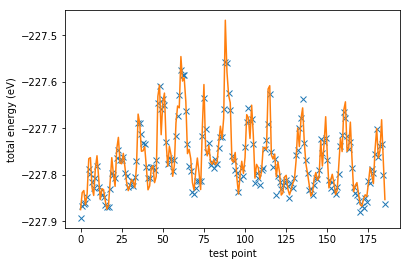

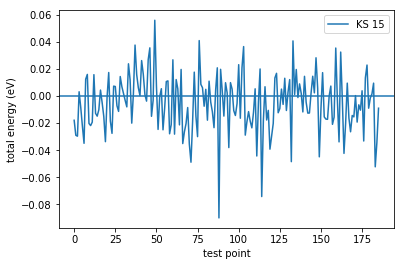

The KRR max error in kcal/mol is 2.094946856033175
The KRR MAE in kcal/mol is 0.3950541296215408


In [262]:



# choose hyperparameter grids
alphas = np.logspace(-20, -1, 6)
gammas = np.logspace(-2, 1, 100)

for n in range(len(Ms)):
    M = Ms[n]  
    
    # split into test and training
    [train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N,input_dim,\
                                                                                         pos, ens, fours)
    print(pos)
    if M < 10:
        cv = M-1
    else:
        cv = 9

    # fit the model and make plots
    print('\n Current training set size: '+str(M))
    
    [kr, y_kr, errs, MAE, max_err] = fit_KS(train_set, train_ens, \
                                            test_set, test_ens, alphas, \
                                            gammas, cv)
    
    print(kr.best_estimator_)
    
    # plot predictions
    plt.figure()
    plt.plot(y_kr, 'x', label='KS '+str(M))
    plt.plot(test_ens, label='DFT energy')
    plt.xlabel('test point')
    plt.ylabel('total energy (eV)')
    plt.show()
    
    # plot erros
    plt.figure()
    plt.plot(y_kr - test_ens, label='KS '+str(M))
    plt.axhline(0)
    plt.xlabel('test point')
    plt.ylabel('total energy (eV)')
    plt.legend()
    plt.show()
    
    print('The KRR max error in kcal/mol is '+str(max_err / kcal_conv))
    print('The KRR MAE in kcal/mol is '+str(MAE / kcal_conv))

# Silicon Test
(Some code borrowed from Jon Vandermause)

In [263]:
# define scf parameters
pref = 'si'
pseudo_dir = '/n/home03/jonpvandermause/qe-6.2.1/pseudo'
pseudo_dir = '/Users/steven/Documents/Schoolwork/CDMAT275/ESPRESSO/qe-6.0'
outdir='/n/home03/jonpvandermause/Cluster/Si_Supercell_SCF'
alat = 5.431 # lattice parameter of si in angstrom
ecut = 18.0 # plane wave cutoff energy
nk = 8 # size of kpoint grid
dim = 4 # size of supercell
nat = 2 * dim**3


pw_loc = '/n/home03/jonpvandermause/qe-6.2.1/bin/pw.x'
in_name = 'si.scf.in'
out_name = 'si.scf.out'
sh_name = 'Si_Super.sh'
partition = 'kaxiras'
memory = 1000
email = 'torrisi@g.harvard.edu'


def make_struc_super(alat, dim):
    unitcell = crystal('Si', [(0, 0, 0)], spacegroup=227, \
                       cellpar=[alat, alat, alat, 90, 90, 90], \
                      primitive_cell = True)
    multiplier = np.identity(3) * dim
    ase_supercell = make_supercell(unitcell, multiplier)
    structure = Struc(ase2struc(ase_supercell))
    return structure

In [264]:
"""from ase.spacegroup import crystal
from ase.build import *

Sicrystal=make_struc_super(alat,dim=2)
cell=Sicrystal.cell
SiAtoms=[]
for at in Sicrystal.positions:
    SiAtoms.append(Atom(element='Si',position=list(np.array(at[1])*1.02)))
    
print(len(SiAtoms))



config2= ESPRESSO_config()

config2.molecule=False
config2.nk=4

eng3 = MD_engine(cell=Sicrystal.cell,input_atoms=SiAtoms,verbosity=3,model='AIMD',dx=.001,espresso_config=config2)

t0=5
dt=1
eng3.run(t0,dt)
"""

"from ase.spacegroup import crystal\nfrom ase.build import *\n\nSicrystal=make_struc_super(alat,dim=2)\ncell=Sicrystal.cell\nSiAtoms=[]\nfor at in Sicrystal.positions:\n    SiAtoms.append(Atom(element='Si',position=list(np.array(at[1])*1.02)))\n    \nprint(len(SiAtoms))\n\n\n\nconfig2= ESPRESSO_config()\n\nconfig2.molecule=False\nconfig2.nk=4\n\neng3 = MD_engine(cell=Sicrystal.cell,input_atoms=SiAtoms,verbosity=3,model='AIMD',dx=.001,espresso_config=config2)\n\nt0=5\ndt=1\neng3.run(t0,dt)\n"

# Testing KRR as an engine for MD

In [265]:
print(pos[1])
alat=4.10
Npos=15
Atom1=Atom(position=pos[Npos][:3]*alat,element='Al')
Atom2=Atom(position=pos[Npos][3:6]*alat,element='Al')
Atom3=Atom(position=pos[Npos][6:9]*alat,element='Al')
Atom4=Atom(position=pos[Npos][9:]*alat,element='Al')
atoms=[Atom1,Atom2,Atom3,Atom4]

KRR_eng = MD_engine(cell=alat*np.eye(3),input_atoms=atoms,ML_model=THEkr,model='KRR',
                    store_trajectory=True,verbosity=4,assert_boundaries=False,dx=.1,fd_accuracy=4)

KRR_eng.run(1,.1)


[ 0.00074764 -0.0064462   0.0028504   0.00168686  0.506051    0.497625
  0.500916   -0.00914685  0.494049    0.496649    0.509542    0.00547559]
E0: [[-227.83066703]]
T= 0.1
Atom 0: [-0.044   0.053  -0.0484]  Force: [ 0.127715 -0.318102  0.22515 ]
Atom 1: [0.0131 1.9519 2.1182]  Force: [ 0.001643  0.562104 -0.340801]
Atom 2: [2.1185 0.0367 2.0196]  Force: [-0.343417 -0.265757 -0.052671]
Atom 3: [2.0122 2.0585 0.0105]  Force: [-0.009564  0.273382  0.030542]
E0: [[-227.8309881]]
T= 0.2
Atom 0: [-0.0439  0.0528 -0.0482]  Force: [ 0.127347 -0.317085  0.224543]
Atom 1: [0.0131 1.9523 2.118 ]  Force: [ 0.001395  0.560849 -0.340108]
Atom 2: [2.1183 0.0365 2.0195]  Force: [-0.342861 -0.264784 -0.052295]
Atom 3: [2.0122 2.0587 0.0105]  Force: [-0.009356  0.27248   0.030171]
E0: [[-227.83162703]]
T= 0.30000000000000004
Atom 0: [-0.0437  0.0524 -0.048 ]  Force: [ 0.126612 -0.315054  0.22333 ]
Atom 1: [0.0131 1.953  2.1176]  Force: [ 0.000901  0.558343 -0.338724]
Atom 2: [2.1179 0.0362 2.0195]  Fo

In [266]:
alat=4.10

Atom1=Atom(position=pos[Npos][:3]*alat,element='Al')
Atom2=Atom(position=pos[Npos][3:6]*alat,element='Al')
Atom3=Atom(position=pos[Npos][6:9]*alat,element='Al')
Atom4=Atom(position=pos[Npos][9:]*alat,element='Al')
atoms=[Atom1,Atom2,Atom3,Atom4]
config2 = ESPRESSO_config()
config2.molecule=False
Al_AIMD_eng = MD_engine(cell=alat*np.eye(3),input_atoms=atoms,model='AIMD',
                        espresso_config=config2,store_trajectory=True,verbosity=4,assert_boundaries=False)

#Al_AIMD_eng.run(.2,.1)


E0: -227.82986409322075
T= 0.1
Atom 0: [-0.0439  0.053  -0.0484]  Force: [ 0.182121 -0.372097  0.246067]
Atom 1: [0.0131 1.9519 2.1183]  Force: [ 0.052317  0.490883 -0.292039]
Atom 2: [2.1186 0.0367 2.0196]  Force: [-0.258161 -0.308115 -0.017782]
Atom 3: [2.0123 2.0585 0.0105]  Force: [0.023723 0.189328 0.063753]
E0: -227.83014219368923
T= 0.2
Atom 0: [-0.0438  0.0527 -0.0482]  Force: [ 0.181798 -0.371054  0.245368]
Atom 1: [0.0131 1.9523 2.1181]  Force: [ 0.052002  0.48968  -0.291339]
Atom 2: [2.1184 0.0364 2.0196]  Force: [-0.257685 -0.307209 -0.017463]
Atom 3: [2.0123 2.0586 0.0106]  Force: [0.023886 0.188583 0.063434]


In [269]:
alat=4.10

Atom1=Atom(position=pos[Npos][:3]*alat,element='Al')
Atom2=Atom(position=pos[Npos][3:6]*alat,element='Al')
Atom3=Atom(position=pos[Npos][6:9]*alat,element='Al')
Atom4=Atom(position=pos[Npos][9:]*alat,element='Al')
atoms=[Atom1,Atom2,Atom3,Atom4]

run_espresso(atoms,cell=alat*np.eye(3),qe_config=config2,ecut=40,molecule=True,
             stepcount = config2.get_correction_number(),iscorrection=True)


KeyboardInterrupt: 

In [ ]:
def get_aug_values(correction_folder,keyword='step'):
    energies=[]
    positions=[]
    if len([folder for folder in list(os.walk(correction_folder))[0][1]])>0:
        
    for fold in [folder for folder in list(os.walk(correction_folder))[0][1] if keyword in folder]:
        with open(fold+'/en','r') as f:
            energies.append(float(f.readlines()[0]))
        
        with open(fold+'/pos','r') as f:
            read_pos=f.readlines()
            for n in range(len(positions)):
                positions.append(read_pos[n])
                
        
        
    

if uncertainty>deviation_threshold:
    run_espresso(atoms,cell,qe_config=config2,ecut=40,molecule=True,stepcount=config2.get_correction_number())
    if self.model=='KRR':
        init_train_set = self.ML_model.original_train_set
        init_train_ens = self.ML_model.original_train_ens
        
        aug_train_set,aug_train_ens = get_aug_values(config2.correction_folder)
        
        new_train_set = np.concatenate(init_train_set,aug_train_set)
        new_train_ens = np.concatenate(init_train_ens,aug_train_ens)
        
        self.ML_model.quick_fit(new_train_set,new_train_ens,alpha,gamma)
        
        
        
    

# Gaussian Processes

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import theano
from KRR_Functions import *
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets